# Handwritten Digit Recognition with CNN

In [1]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

from sklearn.model_selection import KFold

from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.optimizers import SGD

# Load Dataset

In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
print(f"train: {X_train.shape, y_train.shape}")
print(f"test: {X_test.shape, y_test.shape}")

train: ((60000, 28, 28), (60000,))
test: ((10000, 28, 28), (10000,))


In [3]:
print(X_train[0])
print(y_train[0])

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   3  18  18  18 126 136
  175  26 166 255 247 127   0   0   0   0]
 [  0   0   0   0   0   0   0   0  30  36  94 154 170 253 253 253 253 253
  225 172 253 242 195  64   0   0   0   0]
 [  0   0   0   0   0   0   0  49 238 253 253 253 253 253 253 253 253 251
   93  82  82  56  39   0   0   0   0   0]
 [  0   0   0   0   0   0   0  18 219 253 253 253 253 253 198 18

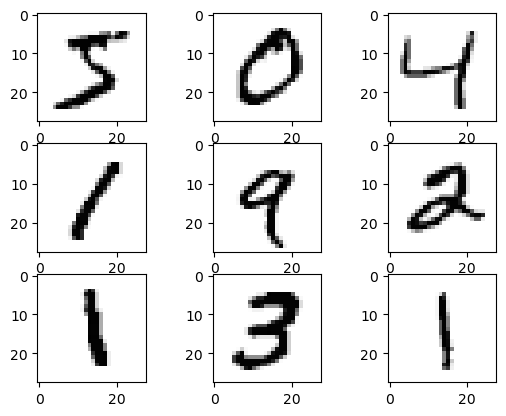

In [4]:
%matplotlib inline
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(X_train[i], cmap="Greys")
plt.show()

# Data Preprocessing

In [5]:
def preprocess_data(X_train, y_train, X_test, y_test):
    # make 1 color channel - grayscale
    X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
    X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)
    
    # one hot encode - convert to 10 element binary vector
    y_train = to_categorical(y_train)
    y_test = to_categorical(y_test)
    
    print(f"train: {X_train.shape, y_train.shape}")
    print(f"test: {X_test.shape, y_test.shape}")
    
    # normalize 0-255 => 0-1
    X_train = X_train.astype('float32') / 255
    X_test = X_test.astype('float32') / 255
    
    return X_train, y_train, X_test, y_test

In [6]:
X_train, y_train, X_test, y_test = preprocess_data(X_train, y_train, X_test, y_test)

train: ((60000, 28, 28, 1), (60000, 10))
test: ((10000, 28, 28, 1), (10000, 10))


# CNN

In [7]:
def make_model():
    model = Sequential()
    model.add(Conv2D(32, (3,3), activation='relu', input_shape=(28,28,1)))  # first hidden layer
    model.add(MaxPooling2D((2,2)))  # retain most prominent features of image
    model.add(Conv2D(64, (3,3), activation='relu'))
    model.add(MaxPooling2D((2,2)))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(10, activation='softmax')) # output layer, probabilities for each possible output

    model.compile(optimizer=SGD(learning_rate=0.01, momentum=0.9),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [8]:
model = make_model()

Metal device set to: Apple M1


2023-04-10 16:39:27.312217: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-04-10 16:39:27.312364: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


# Model Evaluation

In [9]:
def evaluate_model():
    kfold = KFold(5, shuffle=True, random_state=1)
    scores, histories = [], []
    for train_ix, test_ix in kfold.split(X_train):  # train + validation in X_train
        model = make_model()

        X_t = X_train[train_ix]
        y_t = y_train[train_ix]
        X_v = X_train[test_ix]
        y_v = y_train[test_ix]

        hist = model.fit(X_t, y_t, epochs=10, batch_size=32, validation_data=(X_v,y_v), verbose=0)
        _, acc = model.evaluate(X_v, y_v, verbose=0)
        print(acc)

        scores.append(acc)
        histories.append(hist)

    return scores, histories

In [10]:
scores, histories = evaluate_model()

2023-04-10 16:39:27.785091: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-04-10 16:39:28.082184: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-10 16:39:44.294624: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


0.9858333468437195


2023-04-10 16:42:37.094306: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-10 16:42:53.002158: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


0.9892500042915344


2023-04-10 16:45:45.897141: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-10 16:46:01.822344: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


0.9883333444595337


2023-04-10 16:48:57.039715: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-10 16:49:12.941230: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


0.9908333420753479


2023-04-10 16:52:07.693944: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-10 16:52:23.652159: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


0.9883333444595337


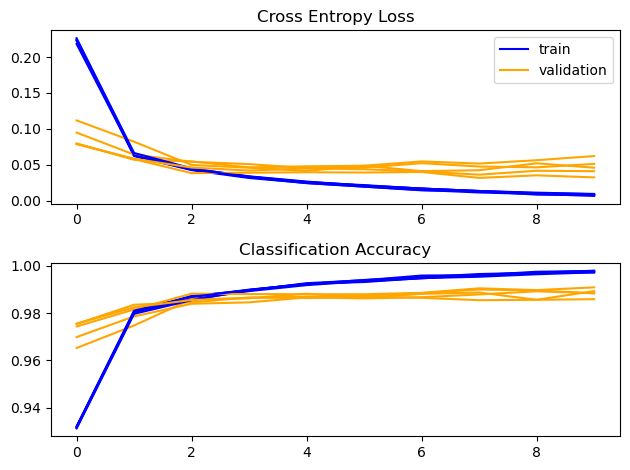

In [12]:
train_line = Line2D([0], [0], label='train', color='blue')
valid_line = Line2D([0], [0], label='validation', color='orange')

for i in range(len(histories)):
    plt.subplot(2,1,1)
    plt.title("Cross Entropy Loss")
    plt.plot(histories[i].history['loss'], color='blue', label='train')
    plt.plot(histories[i].history['val_loss'], color='orange', label='validation')
    plt.legend(handles=[train_line, valid_line], loc='upper right')
    
    plt.subplot(2,1,2)
    plt.title("Classification Accuracy")
    plt.plot(histories[i].history['accuracy'], color='blue', label='train')
    plt.plot(histories[i].history['val_accuracy'], color='orange', label='validation')

plt.tight_layout()
plt.show()

In [13]:
print(f'Accuracy: mean={np.mean(scores):.4f}, std={np.std(scores):.4f}, n={len(scores)}')

Accuracy: mean=0.9885, std=0.0016, n=5


# Save Final Model

In [14]:
model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)
model.save('cnn_model.h5')

2023-04-10 16:57:58.580338: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [15]:
model = load_model('cnn_model.h5')
score = model.evaluate(X_test, y_test, verbose=0)
print(f'test loss: {score[0]}')
print(f'test accuracy: {score[1]}')

2023-04-10 17:01:17.500085: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


test loss: 0.02917952463030815
test accuracy: 0.9910000562667847
